#**Clustering Stocks**
Cluster analysis is used as a multivariate analytical method, to identify the best stocks based on indicators to make a portfolio. Clustering can also help diversify a portfolio. I will also consider high earners who show possible signs of weakness and vice versa. 


#Intro

###The Libraries

In [ ]:
#libraries
import requests
import pandas as pd

#scale and visualize
import numpy as np
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

#model
from sklearn.cluster import KMeans
from sklearn import metrics

#evaluate
from yellowbrick.cluster import SilhouetteVisualizer

#umap
!pip install umap-learn[plot]
!pip install hdbscan
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Dimension reduction and clustering libraries
import umap
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

#imputation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

#regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


###Tickers

In [ ]:
#load the tickers into data frame
symbols_stock = pd.read_csv('/content/stock_list.csv')

#remove carrot character for API usability
symbols_stock['Symbol'] = symbols_stock['Symbol'].str.replace('^', '')

#print the data frame shape
display(symbols_stock.shape)

(5807, 1)

###Chunks

In [ ]:
#chunk size
x = 100

#break frame into chunks
chunk_symbols = [symbols_stock[i:i+x] for i in range (0, symbols_stock.shape[0], x)]

#example
chunk_example = list(chunk_symbols[0]['Symbol'])
chunk_example[:5]

['A', 'AA', 'AABA', 'AAC', 'AAL']

#**The Data**


##Data Points

In [ ]:
#define endpoint (instruments)
endpt = "https://api.tdameritrade.com/v1/instruments"

#storage 
dict_stock= {}

#loop through chunks
for group in chunk_symbols:

  #define payload
  payload= {'apikey': 'YYQWLH0A6HZG2NECJNRT0V5EXLYDWO3H',
            'projection' : 'fundamental',
            'symbol': list(group['Symbol'])}
  
  #make request
  cont = requests.get(url = endpt, params = payload)

  #convert it to dict
  info = cont.json()

  #loop through each stock, grab and store data
  try:
    for stock in info:
      dict_stock[info[stock]['cusip']] = info[stock]['fundamental']
  except:
    continue

#create df for new data

df_stock = pd.DataFrame(dict_stock)
df_stock.head()

,037833100,00773U108,05464C101,003881307,464288182,00770C101,00081T108,00548A106,00547W208,00211Y506,G8789K124,00430K402,049164205,006739106,013872106,01881G106,045528106,G33032106,006351308,00287Y109,02376R102,00258W108,00751Y106,024013104,020283305,054540208,G0084W101,007624307,00846U101,000375204,03073E105,043436104,000868109,000957100,038923108,00444P108,002824100,00108J109,03076K108,039653100,...,37954Y707,983919101,98872F204,24906P109,98850P109,98978L204,98421M106,98923T104,G98338109,98585X104,988498101,967590209,987537206,984015503,985817105,98980M109,98400H102,98920Y304,98422L107,302104104,98401F105,53634Q204,98400T106,962166104,98419J206,12482W101,98420P308,987184108,171798101,98887Q104,46434V381,524682309,98389B100,989817101,98979V102,98983V106,98978V103,98986M103,98986X109,98985W102
symbol,AAPL,ADVM,AAXN,ACTG,AAXJ,ADES,ACCO,ADMS,ADMP,ABIO,ABIL,ACST,AAWW,ADUS,AA,AB,AC,AAC,AE,ABBV,AAL,AAN,AAP,AAT,AAU,ACLS,ADNT,ADXS,A,ABB,ABC,ABG,ACNB,ABM,ABR,ACER,ABT,ACMR,ABCB,ACA,...,YLCO,XLNX,YUMA,XRAY,YUMC,ZGNX,XRX,ZDGE,YTRA,YETI,YUM,WYY,YGYI,XBIO,YELP,ZOM,XBIT,ZEAL,XERS,XONE,XNCR,YVR,XFLT,WY,XOMA,YCBD,XTNT,YORW,XEC,ZLAB,XT,YLDE,XEL,ZUMZ,ZVO,ZUO,ZTS,ZYXI,ZYNE,ZYME
high52,145.09,26.98,177.705,9.09,102.44,8,9.56,9.15,2.34,22,2.78,1.22,69.08,129.005,37.06,42.9291,45.49,10,37.7,113.41,26.09,27.18,202.54,36.6,1.24,50.2093,49.14,1.57,137.827,33.48,121.82,216.88,33.7388,55.48,17.72,5.84,128.54,144.806,57.81,68.46,...,20.2499,154.93,8.6055,66.92,64.64,32.42,26.96,16.94,2.94,89.7,118.97,15.885,1.85,5.85,43.86,2.91,21.48,44.42,7.94,66.4791,58.345,7.5,9.48,39.785,46.32,6.83,6.58,52.5,69.35,193.54,62.56,39.3598,76.44,49.23,7.3399,17.95,176.64,29.7271,9,59.03
low52,69.55,8.58,50.051,2.225,61.66,3.5193,5.2,2.43,0.3755,3.2,0.2468,0.171,29.88,73.79,6.38,20,30.21,9.5,18.36,79.1101,8.25,16.2,115,20.73,0.375,20.4,12.11,0.2639,73.42,16.8,81.51,56.01,19,28.21,5.665,1.91,86.16,34.57,17.12,31.03,...,10.02,80.45,1.15,36.12,43.5,17.2033,14.22,0.852,0.5427,24.63,77.58,4.002,0.24,0.76,17.835,0.0628,12.76,29.43,1.87,6.64,26.8,1.27,4.39,16.05,15.48,0.8,0.629,39.5,21.14,58.59,38.7,27.7729,56.07,16.765,1.31,9.15,121.5,12.53,3.12,24.82
dividendAmount,0.82,0,0,0,0.947477,0,0.26,0,0,0,0,0,0,0,0,2.91,0.2,0,0.96,5.2,0,0.4,4,1.12,0,0,0,0,0.776,0.87,1.76,0,1,0.76,1.32,0,1.8,0,0.6,0.2,...,0.33493,0,0,0.4,0.48,0,1,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0.876,0.68,0,0,0,0.7496,1.08,0,0.428305,0.4559,1.83,0,0,0,1,0,0,0
dividendYield,0.61,0,0,0,1,0,3.04,0,0,0,0,0,0,0,0,6.83,0.57,0,3.6,4.67,0,1.55,2.03,3.25,0,0,0,0,0.57,2.67,1.47,0,3.63,1.43,7.6,0,1.47,0,1.17,0.31,...,1.85,0,0,0.6,0.81,0,4.1,0,0,0,1.73,0,0,0,0,0,0,0,0,0,0,0,10.13,1.78,0,0,0,1.48,1.72,0,0.69,1.16,2.59,0,0,0,0.59,0,0,0


##Dataframe

data loaded using the TD ameritrade api which has a package of fundamental indicators.
* price
* dividends
* margin
* market 
* return
* debt
* volume

In [ ]:
#transpose to make the data cats the df columns
df_stock = df_stock.transpose()

display(df_stock.head())
display(df_stock.shape)

,symbol,high52,low52,dividendAmount,dividendYield,dividendDate,peRatio,pegRatio,pbRatio,prRatio,pcfRatio,grossMarginTTM,grossMarginMRQ,netProfitMarginTTM,netProfitMarginMRQ,operatingMarginTTM,operatingMarginMRQ,returnOnEquity,returnOnAssets,returnOnInvestment,quickRatio,currentRatio,interestCoverage,totalDebtToCapital,ltDebtToEquity,totalDebtToEquity,epsTTM,epsChangePercentTTM,epsChangeYear,epsChange,revChangeYear,revChangeTTM,revChangeIn,sharesOutstanding,marketCapFloat,marketCap,bookValuePerShare,shortIntToFloat,shortIntDayToCover,divGrowthRate3Year,dividendPayAmount,dividendPayDate,beta,vol1DayAvg,vol10DayAvg,vol3MonthAvg
037833100,AAPL,145.09,69.55,0.82,0.61,2021-02-05 00:00:00.000,36.4197,2.16007,34.2237,7.6893,30.222,38.7805,39.7778,21.7349,25.8033,25.2445,30.0918,82.0905,18.4058,27.7954,1.12547,1.163,0,62.8512,149.917,169.188,3.6991,16.8604,34.6424,0,0,9.88184,72.2449,1.67881e+10,16775.4,2.26169e+06,0,0,0,0,0.205,2021-02-11 00:00:00.000,1.21352,8.40911e+07,8.40911e+07,2.1665e+09
00773U108,ADVM,26.98,8.58,0,0,,0,0,2.23689,0,0,0,0,0,0,0,0,0,0,0,0,20.8154,0,0,0,0,0,0,0,0,0,0,0,9.7927e+07,96.7409,975.352,0,0,0,0,0,,1.4274,817090,817087,1.63535e+07
05464C101,AAXN,177.705,50.051,0,0,,0,0,12.3908,17.6987,0,58.6655,59.0236,0,0,0,0,0,0,0,3.00997,3.38749,0,0,0,0,0,0,0,0,0,32.274,17.8275,6.35499e+07,62.818,11092,30.2586,0,0,0,0,,0.59526,1.01501e+06,0,1.24577e+07
003881307,ACTG,9.09,2.225,0,0,,3.9444,0.007274,1.06967,10.11,3.21699,75.324,88.4554,380.915,1830.69,0,0,39.7394,30.9246,38.8324,0,3.66675,0,27.5969,0,39.5549,1.54903,542.264,20159.2,0,0,164.823,0,4.92795e+07,46.3117,301.098,0,0,0,0,0,,0.55713,605190,605192,2.51311e+07
464288182,AAXJ,102.44,61.66,0.947477,1,2020-12-14 00:00:00.000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7.16e+07,54.0709,4329.23,0,0,0,0,0.684328,2020-12-18 00:00:00.000,0.87806,829820,998854,2.62534e+07


(4737, 46)

#**The Features**



* ROA: Return on assets describes how profitable a company is relative to its total assets. 
* ROE: Return on equity compares a company's profits to the company's assets minus its debt. 
* ROI: It compares the investment's returns to its initial cost. 





How were the features selected?
* stock price as a function of earnings, value/marketplace

* "Stock selection based on cluster analysis"

* "The Classification of Stocks with Basic Financial Indicators: An Application of Cluster Analysis on the BIST 100 Index"

* less features = faster performance speed, closer groupings, easier to visualize

* NYU industry benchmarks for financial metrics

##Features

In [ ]:
# demarcate indicators
list_metrics = ['returnOnEquity','returnOnAssets','returnOnInvestment','symbol']

# select columns
df_indicators = df_stock[list_metrics]

# display df
display(df_indicators.head())

# clean up missing values
df_indicators = df_indicators[df_indicators[list_metrics] != 0]
df_indicators = df_indicators.dropna(how='any')

display(df_indicators.head())

,returnOnEquity,returnOnAssets,returnOnInvestment,symbol
037833100,82.0905,18.4058,27.7954,AAPL
00773U108,0,0,0,ADVM
05464C101,0,0,0,AAXN
003881307,39.7394,30.9246,38.8324,ACTG
464288182,0,0,0,AAXJ


,returnOnEquity,returnOnAssets,returnOnInvestment,symbol
037833100,82.0905,18.4058,27.7954,AAPL
003881307,39.7394,30.9246,38.8324,ACTG
00081T108,8.17726,2.12427,2.64302,ACCO
049164205,17.7756,6.3126,7.85923,AAWW
006739106,6.6648,4.33301,5.10563,ADUS


In [ ]:
# change the index to ticker
df_indicators = df_indicators.set_index('symbol')

# convert the data type
df_indicators = df_indicators.astype('float')

df_indicators.head()

,returnOnEquity,returnOnAssets,returnOnInvestment
symbol,,,
AAPL,82.09046,18.40581,27.79541
ACTG,39.73938,30.92461,38.83240
ACCO,8.17726,2.12427,2.64302
AAWW,17.77558,6.31260,7.85923
ADUS,6.66480,4.33301,5.10563


##Outliers

From consulting NYU industry standards table:
40%, 30%, and 30% cutoff values for ROE, ROA, and ROI respectively

In [ ]:
# define the filters
filter_roe = df_indicators.iloc[:,0] < 40
filter_roa = df_indicators.iloc[:,1] < 30
filter_roi = df_indicators.iloc[:,2] < 30

# get the counts for each column
count_roe = pd.Series(filter_roe).value_counts()
count_roa = pd.Series(filter_roa).value_counts()
count_roi = pd.Series(filter_roi).value_counts()

# display the results
display(count_roe)
display(count_roa)
display(count_roi)

# filter the data frame
df_indicators = df_indicators[filter_roe & filter_roa & filter_roi]

# display the results
df_indicators.head()

True     1556
False     174
Name: returnOnEquity, dtype: int64

True     1686
False      44
Name: returnOnAssets, dtype: int64

True     1643
False      87
Name: returnOnInvestment, dtype: int64

,returnOnEquity,returnOnAssets,returnOnInvestment
symbol,,,
ACCO,8.17726,2.12427,2.64302
AAWW,17.77558,6.31260,7.85923
ADUS,6.66480,4.33301,5.10563
AB,17.71657,17.68062,17.68062
AC,6.80088,2.10367,2.43643


##The Data

In [ ]:
# create a statistical summary
df_desc = df_indicators.describe()

# add the standard deviation metric
df_desc.loc['+3_std'] = df_desc.loc['mean'] + (df_desc.loc['std'] * 3)
df_desc.loc['-3_std'] = df_desc.loc['mean'] - (df_desc.loc['std'] * 3)

# display it
df_desc

,returnOnEquity,returnOnAssets,returnOnInvestment
count,1538.000000,1538.000000,1538.000000
mean,11.905045,5.674717,7.187566
std,8.874180,4.711721,5.941562
min,0.011130,0.036020,0.046490
25%,4.933827,2.210735,2.715723
50%,10.124880,4.388690,5.530500
75%,16.787968,7.727335,9.952818
max,39.896820,28.250780,29.830150
+3_std,38.527584,19.809879,25.012252
-3_std,-14.717493,-8.460445,-10.637120


##Scale and Visualize

What sampling techniques did you use to aid in training your model?

* normalized the data using scaling to improve performance of the model

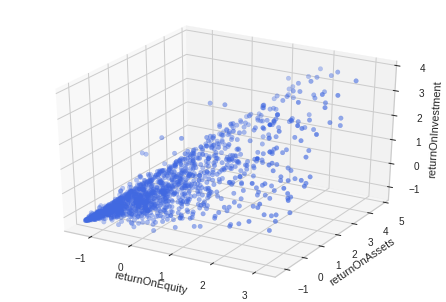

In [ ]:
# create the scaler
scaler_std = StandardScaler()

# pass the data through the scaler
standard_X_train = scaler_std.fit_transform(df_indicators)

# create a scatter plot
fig = plt.figure()
ax = Axes3D(fig)

# assign the axes with the scaled data
x = standard_X_train[:,0]
y = standard_X_train[:,1]
z = standard_X_train[:,2]

# label the axes
names_column = df_indicators.columns
ax.set_xlabel(names_column[0])
ax.set_ylabel(names_column[1])
ax.set_zlabel(names_column[2])

# plot the graph
ax.scatter(x, y, z, c='royalBlue')

plt.show()

#**The Model**

##K-Means

How did you go about investigating the relationship between your features and the target?

* Using SilhouetterVisualizer to evaluate the cluster distributions -- Silhouette analysis can be used to study the separation distance between the resulting clusters.
Testing the results using different numbers of clusters

What sampling techniques did you use to aid in training your model?

* determined the optimum number of clusters

why use k-means?

* K-means use a centroid function in order to cluster the data.

* It is unsupervised meaning that it is able to detect patterns with no prior training.

In [ ]:
# define a dict to hodl info
dict_results = {}

# define test range of clusters
clusters_num = 10

# test the diff cluster arrangements
for k in range(2, clusters_num):
    
    print("-"*100)
    
    # create dict to hold the results
    dict_results[k] = {}

    # fit the model
    k_means = KMeans(n_clusters=k, random_state=0).fit(standard_X_train)
    
    # initiate the silhouette score
    score_sil = metrics.silhouette_score(standard_X_train, k_means.labels_, metric='euclidean')
    
    # store the results
    dict_results[k]['silhouette_score'] = score_sil
    dict_results[k]['inertia'] = k_means.inertia_
    dict_results[k]['score'] = k_means.score
    dict_results[k]['model'] = k_means
    
    # print the results    
    print("Number of Clusters: {}".format(k))
    print('Silhouette Score:', score_sil)

----------------------------------------------------------------------------------------------------
Number of Clusters: 2
Silhouette Score: 0.5669514223508549
----------------------------------------------------------------------------------------------------
Number of Clusters: 3
Silhouette Score: 0.47346289897045746
----------------------------------------------------------------------------------------------------
Number of Clusters: 4
Silhouette Score: 0.4264836951483936
----------------------------------------------------------------------------------------------------
Number of Clusters: 5
Silhouette Score: 0.4318382246848817
----------------------------------------------------------------------------------------------------
Number of Clusters: 6
Silhouette Score: 0.41181138698229564
----------------------------------------------------------------------------------------------------
Number of Clusters: 7
Silhouette Score: 0.40987737568548827
-------------------------------------

##Visualize

* +1 indicate that the sample is far away from the neighboring clusters. 
* 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters
* negative values indicate that those samples might have been assigned to the wrong cluster.

* looking for each cluster to exceed the red line or the average silhouette score
* that the clusters are as evenly distributed as possible.

----------------------------------------------------------------------------------------------------


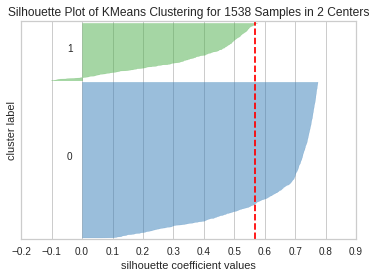

----------------------------------------------------------------------------------------------------


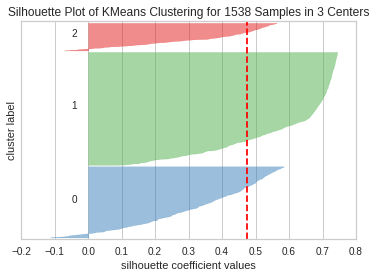

In [ ]:
clusts = [2,3]

for clust in clusts:
    
    print('-'*100)

    # define the model for K
    k_means = KMeans(n_clusters = clust, random_state=0)

    # pass the model through the visualizer
    visualize = SilhouetteVisualizer(k_means)

    # fit the data
    visualize.fit(standard_X_train)

    # show the chart
    visualize.poof()

----------------------------------------------------------------------------------------------------


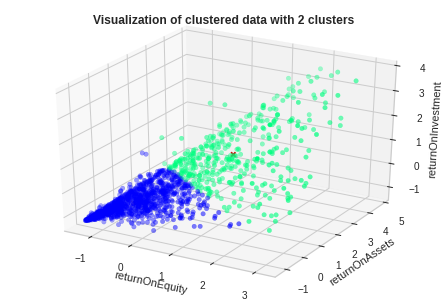

----------------------------------------------------------------------------------------------------


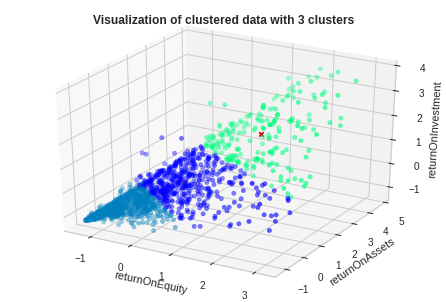

In [ ]:
clusts = [2,3]

for clust in clusts:
    
    print('-'*100)
    
    k_means = KMeans(n_clusters= clust, random_state=0).fit(standard_X_train)
    
    # define the cluster centers
    cluster_cents = k_means.cluster_centers_
    C_1 = cluster_cents[:, 0]
    C_2 = cluster_cents[:, 1]
    C_3 = cluster_cents[:, 2]


    # create a new plot
    fig = plt.figure()
    ax = Axes3D(fig)

    # take the scaled data in this example.
    x = standard_X_train[:,0]
    y = standard_X_train[:,1]
    z = standard_X_train[:,2]

    # define the axes labels
    col_names = df_indicators.columns
    ax.set_xlabel(col_names[0])
    ax.set_ylabel(col_names[1])
    ax.set_zlabel(col_names[2])

    # create a new plot
    ax.scatter(x, y, z, c = k_means.labels_.astype(float), cmap='winter')
    ax.scatter(C_1, C_2, C_3, marker="x", color='r')

    plt.title('Visualization of clustered data with {} clusters'.format(clust), fontweight='bold')

    plt.show()

we have

* loaded the data
* selected earnings based metrics to cluster stock prices

now we will

* exclude the previously specified features from the dataset
* predict which cluster (earnings group) the stock would fall into
* consider reasons why there is this variation?
** company stage development
** market trends
* discuss how this is useful?
** choosing portfolio from the middle category could reduce risk
** looking at stocks which have metrics that are dissimilar from those of other stocks in their cluster grouping may indicate that there is an upcoming value adjustment due to reasons such as market trends or development



##grab classifications


In [ ]:
#create dataframe for standardized data
X_df = pd.DataFrame(standard_X_train)
X_df.columns = df_indicators.columns
X_df['symbol'] = df_indicators.index
X_df = X_df.set_index('symbol')

#add a column for the cluster assignments
X_df['rank'] = k_means.predict(X_df)
X_df.head()

#create a column in the stocks dataframe for rank
df_stock['rank']= [0]*(len(df_stock))

#make the stocks dataframe index the ticker
df_stock = df_stock.set_index('symbol')

#get rid of the rows that were not predicted for
ticker_list = X_df.index

for symbol in df_stock.index:
  if symbol not in ticker_list:
    df_stock.drop([symbol], inplace=True)

In [ ]:
X_df

,returnOnEquity,returnOnAssets,returnOnInvestment,rank
symbol,,,,
ACCO,-0.420208,-0.753780,-0.765123,1
AAWW,0.661745,0.135426,0.113082,0
ADUS,-0.590697,-0.284852,-0.350516,1
AB,0.655093,2.548922,1.766617,2
AC,-0.575357,-0.758154,-0.799904,1
...,...,...,...,...
XOMA,0.216191,1.350091,1.030639,0
YORW,0.006785,-0.290066,-0.458237,1
XEL,-0.148034,-0.605712,-0.691275,1


In [ ]:
#transfer the ranks
df_stock['rank'] = X_df['rank']
df_stock

,high52,low52,dividendAmount,dividendYield,dividendDate,peRatio,pegRatio,pbRatio,prRatio,pcfRatio,grossMarginTTM,grossMarginMRQ,netProfitMarginTTM,netProfitMarginMRQ,operatingMarginTTM,operatingMarginMRQ,returnOnEquity,returnOnAssets,returnOnInvestment,quickRatio,currentRatio,interestCoverage,totalDebtToCapital,ltDebtToEquity,totalDebtToEquity,epsTTM,epsChangePercentTTM,epsChangeYear,epsChange,revChangeYear,revChangeTTM,revChangeIn,sharesOutstanding,marketCapFloat,marketCap,bookValuePerShare,shortIntToFloat,shortIntDayToCover,divGrowthRate3Year,dividendPayAmount,dividendPayDate,beta,vol1DayAvg,vol10DayAvg,vol3MonthAvg,rank
symbol,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ACCO,9.56,5.2,0.26,3.04,2021-03-16 00:00:00.000,13.2255,0,1.09298,0.49324,6.15225,29.7487,31.1019,3.74577,6.47685,6.79072,9.17192,8.17726,2.12427,2.64302,0.75974,1.3076,6.68421,60.364,141.995,152.296,0.64648,0,0,0,0,0,3.60279,9.54857e+07,91.7825,816.403,7.29292,0,0,0,0.065,2021-03-29 00:00:00.000,2.22031,355280,355280,1.12228e+07,1
AAWW,69.08,29.88,0,0,,5.07481,0.02353,0.81924,0.60821,2.83713,58.3403,60.5142,11.22,19.7289,13.1927,21.0346,17.7756,6.3126,7.85923,0,1.06149,4.62804,50.6287,89.3397,102.547,13.2675,215.674,141.444,0,0,17.2287,15.1366,2.9007e+07,27.1349,1953.04,6.8445,0,0,0,0,,1.31344,417840,417840,1.10044e+07,0
ADUS,129.005,73.79,0,0,,51.693,2.56204,3.23284,2.22192,37.567,29.5822,30.1557,4.33239,4.3108,5.81962,5.97767,6.6648,4.33301,5.10563,0,1.99927,19.0769,27.3103,37.3838,37.571,2.07707,20.1765,0,0,0,18.3025,1.03564,1.58263e+07,15.5749,1699.27,21.0868,0,0,0,0,,0.71584,56490,56493,1.76426e+06,1
AB,42.9291,20,2.91,6.83,2021-02-19 00:00:00.000,15.0289,1.07138,2.61254,13.591,0,0,0,90.589,91.8957,100,100,17.7166,17.6806,17.6806,0,0,0,0,0,0,2.83653,14.0277,10.1028,0,0,15.8142,37.2811,9.83229e+07,96.3114,4191.51,0.70611,0,0,0,0.97,2021-03-04 00:00:00.000,1.41306,363450,363446,1.06726e+07,2
AC,45.49,30.21,0.2,0.57,2020-11-30 00:00:00.000,40.2785,0,0.87021,41.0943,37.9404,18.098,19.7175,108.039,439.271,8.04428,9.60532,6.80088,2.10367,2.43643,0,0.57912,7.7608,56.9407,131.018,132.238,0.87193,0,378.491,0,0,9.33112,517.429,3.24931e+06,37.071,780.093,6.50489,0,0,0,0.1,2020-12-15 00:00:00.000,1.3053,9560,9556,382750,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XOMA,46.32,15.48,0,0,,103.437,0.416193,4.90232,14.4467,32.0836,0,0,45.2528,82.1798,42.2514,86.5523,13.8229,12.0339,13.3092,0,7.15859,19.2672,19.4377,14.7691,24.1276,0.36457,248.531,362.525,0,0,59.9673,4851.71,1.12578e+07,10.4114,424.53,0,0,0,0,0,,0.92145,22560,22555,1.23851e+06,0
YORW,52.5,39.5,0.7496,1.48,2021-02-25 00:00:00.000,39.7123,2.71048,4.61066,12.2673,26.6647,0,0,30.8215,27.6907,46.3233,41.0584,11.9652,4.30845,4.46581,1.27408,1.35829,6.6504,46.3124,86.2627,86.2627,1.27341,14.6514,8.81451,0,0,4.40886,0,1.30634e+07,12.8843,660.619,5.19884,0,0,0,0.1874,2021-04-15 00:00:00.000,0.20698,29670,29668,849880,1
XEL,76.44,56.07,1.83,2.59,2021-03-12 00:00:00.000,25.3157,4.38548,2.6033,3.29586,10.6858,42.6773,38.8243,12.7798,9.77265,18.3585,14.4554,10.5918,2.8217,3.08165,0.64638,0.77259,2.3027,58.7181,135.314,142.237,2.78878,5.77263,0,0,0,0,0,5.38075e+08,523.786,37988.1,5.36116,0,0,0,0.4575,2021-04-20 00:00:00.000,0.29845,3.844e+06,3.844e+06,6.859e+07,1


#**The Imputed Values**

* this step is necessary because at the outset the td api delivered different metrics for all the different stocks. 
* in order to use the date one can use iterative imputer. 
* this is better than using average values to fill in missing data because it essentially weights the data based on observed relationships to give a more nuanced final dataset.

##Imputer


In [ ]:
#drop date values
df_stock.drop(columns= ['dividendPayDate', 'dividendDate'], inplace=True)

In [ ]:
#change datatype to float
df_stock_float = df_stock.apply(pd.to_numeric)
df_stock_float.dtypes

#change 0s to nan
cols = list(df_stock_float.columns)
rank = df_stock['rank']
cols.remove('rank')
df_stock_float[cols] = df_stock_float[cols].replace({0:np.nan})
print(df_stock_float.head())

#get rid of empty columns
df_stock_float = df_stock_float.dropna(axis=1, how='all')

#run multiple imputation
imp = IterativeImputer(max_iter=10, verbose=0)
imp.fit(df_stock_float)
imputed_df = imp.transform(df_stock_float)
imputed_df = pd.DataFrame(imputed_df, columns=df_stock_float.columns)
imputed_df['id'] = range(len(imputed_df))
key = dict(zip(imputed_df['id'], X_df.index))
imputed_df

          high52  low52  dividendAmount  ...  vol10DayAvg  vol3MonthAvg  rank
symbol                                   ...                                 
ACCO      9.5600   5.20            0.26  ...     355280.0    11222850.0     1
AAWW     69.0800  29.88             NaN  ...     417840.0    11004380.0     0
ADUS    129.0050  73.79             NaN  ...      56493.0     1764260.0     1
AB       42.9291  20.00            2.91  ...     363446.0    10672650.0     2
AC       45.4900  30.21            0.20  ...       9556.0      382750.0     1

[5 rows x 44 columns]


,high52,low52,dividendAmount,dividendYield,peRatio,pegRatio,pbRatio,prRatio,pcfRatio,grossMarginTTM,grossMarginMRQ,netProfitMarginTTM,netProfitMarginMRQ,operatingMarginTTM,operatingMarginMRQ,returnOnEquity,returnOnAssets,returnOnInvestment,quickRatio,currentRatio,interestCoverage,totalDebtToCapital,ltDebtToEquity,totalDebtToEquity,epsTTM,epsChangePercentTTM,epsChangeYear,revChangeTTM,revChangeIn,sharesOutstanding,marketCapFloat,marketCap,bookValuePerShare,dividendPayAmount,beta,vol1DayAvg,vol10DayAvg,vol3MonthAvg,rank,id
0,9.5600,5.200,0.260000,3.040000,13.22547,2.169408,1.09298,0.49324,6.152250,29.748670,31.101930,3.74577,6.47685,6.79072,9.17192,8.17726,2.12427,2.64302,0.759740,1.30760,6.684210,60.363970,141.995400,152.295700,0.64648,1987.124257,218.791971,10.408046,3.602790,95485721.0,91.78249,816.4029,7.292920,0.065000,2.22031,355280.0,355280.0,11222850.0,1.0,0
1,69.0800,29.880,1.505915,2.857415,5.07481,0.023530,0.81924,0.60821,2.837130,58.340340,60.514220,11.21996,19.72889,13.19273,21.03456,17.77558,6.31260,7.85923,0.719232,1.06149,4.628040,50.628750,89.339650,102.547000,13.26748,215.673800,141.443800,17.228710,15.136570,29007024.0,27.13485,1953.0430,6.844500,0.347653,1.31344,417840.0,417840.0,11004380.0,0.0,1
2,129.0050,73.790,1.187799,1.293131,51.69301,2.562044,3.23284,2.22192,37.567000,29.582160,30.155720,4.33239,4.31080,5.81962,5.97767,6.66480,4.33301,5.10563,1.343687,1.99927,19.076920,27.310290,37.383840,37.571050,2.07707,20.176470,438.416133,18.302530,1.035640,15826284.0,15.57489,1699.2680,21.086850,0.387220,0.71584,56490.0,56493.0,1764260.0,1.0,2
3,42.9291,20.000,2.910000,6.830000,15.02893,1.071376,2.61254,13.59096,-17.538222,49.179985,51.870734,90.58897,91.89568,100.00000,100.00000,17.71657,17.68062,17.68062,4.224504,5.02710,87.707544,12.001242,10.061797,107.992550,2.83653,14.027690,10.102750,15.814220,37.281050,98322942.0,96.31137,4191.5070,0.706110,0.970000,1.41306,363450.0,363446.0,10672650.0,2.0,3
4,45.4900,30.210,0.200000,0.570000,40.27846,1.918784,0.87021,41.09432,37.940440,18.098000,19.717500,108.03880,439.27050,8.04428,9.60532,6.80088,2.10367,2.43643,0.189115,0.57912,7.760800,56.940700,131.018000,132.237900,0.87193,2293.569150,378.491100,9.331120,517.429300,3249309.0,37.07100,780.0934,6.504890,0.100000,1.30530,9560.0,9556.0,382750.0,1.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1533,46.3200,15.480,-1.940056,26.633714,103.43690,0.416193,4.90232,14.44667,32.083580,43.988000,48.550936,45.25284,82.17976,42.25141,86.55234,13.82294,12.03390,13.30918,4.420767,7.15859,19.267150,19.437710,14.769050,24.127560,0.36457,248.531300,362.524900,59.967340,4851.706000,11257756.0,10.41136,424.5300,15.665289,0.132278,0.92145,22560.0,22555.0,1238510.0,0.0,1533
1534,52.5000,39.500,0.749600,1.480000,39.71227,2.710480,4.61066,12.26730,26.664730,48.094745,49.000973,30.82151,27.69070,46.32326,41.05837,11.96524,4.30845,4.46581,1.274080,1.35829,6.650400,46.312380,86.262670,86.262670,1.27341,14.651380,8.814510,4.408860,14.965452,13063448.0,12.88430,660.6186,5.198840,0.187400,0.20698,29670.0,29668.0,849880.0,1.0,1534
1535,76.4400,56.070,1.830000,2.590000,25.31573,4.385476,2.60330,3.29586,10.685820,42.677280,38.824330,12.77980,9.77265,18.35849,14.45538,10.59179,2.82170,3.08165,0.646380,0.77259,2.302700,58.718060,135.313900,142.236700,2.78878,5.772630,374.358934,20.016535,33.468872,538074813.0,523.78580,37988.0800,5.361160,0.457500,0.29845,3844000.0,3844002.0,68590020.0,1.0,1535
1536,49.2300,16.765,1.038058,2.205716,14.40633,1.010072,1.99105,1.11712,11.035160,35.331780,39.097710,7.69463,12.90870,9.78527,16.23021,14.96581,7.97094,9.78863,2.051260,2.73866,88.471558,32.394444,54.545525,108.934837,2.98341,14.262680,12.622020,19.197797,22.359680,25748543.0,21.30734,1106.6720,13.321390,0.363192,1.77535,173210.0,173208.0,5108730.0,0.0,1536


#**The Predictions**

##Regression

why use logistic regression

* categorical 

* descriptive: relationship between variables represented using a sigmoid curve which can describe exponential relationships

In [ ]:
#multinomial logistic regression
#set features and target
df1 = imputed_df.drop(columns = ['returnOnEquity','returnOnAssets','returnOnInvestment', 'rank'])

In [ ]:
#split, train
X = df1.values
y = list(rank)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
lr = LogisticRegression().fit(X_train, y_train)
yhat = lr.predict(X_train)

In [ ]:
#test
dftrain = pd.DataFrame(X_train, columns = list(df1.columns.values))
dftrain['Actual'] = y_train
dftrain['Predicted'] = yhat
dftrain

,high52,low52,dividendAmount,dividendYield,peRatio,pegRatio,pbRatio,prRatio,pcfRatio,grossMarginTTM,grossMarginMRQ,netProfitMarginTTM,netProfitMarginMRQ,operatingMarginTTM,operatingMarginMRQ,quickRatio,currentRatio,interestCoverage,totalDebtToCapital,ltDebtToEquity,totalDebtToEquity,epsTTM,epsChangePercentTTM,epsChangeYear,revChangeTTM,revChangeIn,sharesOutstanding,marketCapFloat,marketCap,bookValuePerShare,dividendPayAmount,beta,vol1DayAvg,vol10DayAvg,vol3MonthAvg,id,Actual,Predicted
0,137.6100,60.7000,1.574189,4.251114,11.370220,0.025280,2.34822,2.20418,8.17061,67.42317,71.73242,19.61553,31.801030,27.88993,44.27101,2.311830,3.110270,30.068970,37.677660,58.12025,60.456120,5.627860,449.778300,282.957300,40.645630,51.349950,5.357692e+07,45.20164,3428.38700,10.224340,0.361011,1.019560,1289360.0,1289356.0,16925920.0,401.0,2,0
1,1.1600,0.3840,0.919258,-1.804979,185.737023,6.979953,2.55604,1.07938,6.80331,32.15698,32.22914,0.12807,19.809920,21.83777,24.22280,0.973360,1.356420,68.636051,28.543010,7.51099,39.944320,-440.587315,95.059030,115.925800,31.286720,49.569385,3.550704e+08,350.72860,281.50740,9.271700,0.303648,1.794120,1478030.0,1478030.0,104386780.0,574.0,1,1
2,95.1172,20.3893,1.892632,1.082188,132.407500,163.607439,7.89839,35.49335,107.73280,76.80762,78.70591,25.22562,30.567210,44.41330,43.50250,2.699896,2.187890,6.481390,28.865740,19.78523,40.957790,0.527920,0.809300,7.159320,28.876720,7.180130,2.640385e+08,182.72840,21674.57000,13.444144,0.485952,0.858370,1378210.0,1378210.0,47602440.0,1311.0,1,1
3,15.4800,4.3150,0.400000,2.790000,18.046400,0.695887,0.95483,3.39675,21.52341,34.11405,31.29997,15.34856,41.653190,23.53508,39.85762,2.586563,3.392489,33.431419,83.164180,505.36800,505.368000,0.793510,3309.777686,19.618690,24.547500,0.904380,7.120891e+07,54.06656,1019.54200,12.298007,0.100000,1.124220,439290.0,439286.0,14303980.0,1137.0,1,1
4,7.5000,3.1800,1.001526,1.702245,28.573930,3.001792,2.24900,0.38504,10.82072,23.50093,25.27410,1.58955,1.776920,2.27729,2.75451,0.735364,1.327260,5.889110,18.911490,19.96485,23.347120,0.228530,1401.846712,48.152560,4.210940,24.407970,4.996706e+07,35.99416,326.28800,6.921180,0.402285,1.463420,150240.0,150239.0,4559800.0,1150.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1071,54.9590,23.4000,0.440000,0.840000,50.782120,2.926576,6.25065,8.36574,36.54373,65.40977,64.98881,16.40307,18.730690,22.25314,25.42079,2.191210,3.748780,15.545600,18.058540,20.58967,22.038340,1.035010,17.352060,51.420200,10.350420,3.108520,2.059061e+07,17.37807,1082.24200,14.611460,0.110000,1.337870,95170.0,95169.0,2667520.0,763.0,0,1
1072,17.4000,2.7800,1.300936,3.877313,13.293150,2.030905,0.83493,0.79148,3.57894,23.33684,32.72173,6.02203,9.388780,15.82969,18.60199,0.740690,0.819750,1.748660,59.914430,128.87050,149.466300,0.856080,2388.532823,25.669550,26.838440,39.180860,3.556829e+07,30.93031,404.76720,12.726149,0.354575,1.242563,619470.0,619469.0,30098760.0,835.0,1,1
1073,77.9900,36.1867,3.639600,5.020000,25.263490,0.654613,1.07246,5.21348,8.77935,61.10728,58.23389,29.42212,282.557604,16.73020,20.24086,1.866164,2.418556,1.144380,49.832080,107.08180,107.081800,2.870150,38.592990,587.131960,28.936126,30.194622,6.935400e+07,69.05103,5028.62800,12.893543,0.303300,1.643250,960820.0,960815.0,29646980.0,1216.0,1,1
1074,85.6700,56.5600,2.840000,4.320000,1154.494000,11.353559,4.53044,3.35354,52.46865,81.48163,81.16157,0.36048,20.805820,16.48912,35.72295,1.255860,1.403530,14.265704,63.281140,157.37280,172.519500,0.056960,2634.883629,287.224488,9.978170,12.832600,1.256604e+09,1252.14900,82795.52000,2.176350,0.710000,0.411280,6174350.0,6174349.0,162946740.0,559.0,1,1


In [ ]:
#accuracy data
print(accuracy_score(y_train, yhat))
yhat = lr.predict(X_test)
print(accuracy_score(y_test, yhat)) 

0.5027881040892194
0.5216450216450217


##Decision Tree

why use a decision tree?

* categorical data

* detection of nonlinear relationships

* easy to understand

In [ ]:
#split data
X_train, X_test, y_train, y_test = train_test_split(df1, rank, test_size=.5, random_state =80)

In [ ]:
#decision tree
classifier = DecisionTreeClassifier()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[155  53  37]
 [ 58 342  10]
 [ 52  15  47]]
              precision    recall  f1-score   support

           0       0.58      0.63      0.61       245
           1       0.83      0.83      0.83       410
           2       0.50      0.41      0.45       114

    accuracy                           0.71       769
   macro avg       0.64      0.63      0.63       769
weighted avg       0.71      0.71      0.71       769



## look at stocks that may be undervalued
* these stocks are placed in the lowest earner cluster but bear similarities with those in the middle cluster
* possible early stage of development has impacted earning thus far
* worth further investigation for a more high risk high return investment

In [ ]:
#stocks where the actual earnings cluster is lower than the predicted.
#these could imply decreased risk relatively
dftrain['symbol'] = [0]*len(dftrain)
for i in range(len(dftrain)):
  dftrain['symbol'][i] = key.get(dftrain['id'][i])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
dftrain.loc[(dftrain['Actual'] < 1) & (dftrain['Predicted'] > 0)]

,high52,low52,dividendAmount,dividendYield,peRatio,pegRatio,pbRatio,prRatio,pcfRatio,grossMarginTTM,grossMarginMRQ,netProfitMarginTTM,netProfitMarginMRQ,operatingMarginTTM,operatingMarginMRQ,quickRatio,currentRatio,interestCoverage,totalDebtToCapital,ltDebtToEquity,totalDebtToEquity,epsTTM,epsChangePercentTTM,epsChangeYear,revChangeTTM,revChangeIn,sharesOutstanding,marketCapFloat,marketCap,bookValuePerShare,dividendPayAmount,beta,vol1DayAvg,vol10DayAvg,vol3MonthAvg,id,Actual,Predicted,symbol
8,212.6200,98.37,1.723462,3.260694,18.00412,0.031452,2.72808,6.24966,16.41601,92.71220,90.95869,34.70640,25.66900,39.30425,16.96545,6.435820,6.70337,1.222850,19.069410,23.562680,23.562680,11.55902,572.429200,82.015310,2.381280,1.262830,4.454434e+07,43.65553,9270.12100,16.891030,0.433717,0.52469,291830.0,291829.0,7879060.0,1458.0,0,1,UTHR
11,104.9000,48.00,0.700000,0.830000,29.03547,2.451987,2.95284,0.75296,16.97333,17.26130,17.79901,2.59692,3.02260,4.15865,4.79741,0.611050,1.28736,25.300620,14.599990,12.142730,17.115230,2.88888,11.841610,9.587170,3.535740,6.853750,3.074950e+07,27.48103,2579.26800,7.635300,0.350000,0.82102,121480.0,121483.0,2786560.0,1108.0,0,1,PSMT
13,17.8600,9.85,0.240000,1.840000,12.27841,3.132661,1.53738,2.79565,9.90616,15.30867,15.14349,22.76913,10.97407,10.92345,11.42129,9.358430,10.38575,35.303685,8.226508,-3.495498,70.236502,1.06447,1113.725523,199.354893,20.197393,36.668148,4.374324e+07,25.64514,571.72420,12.558998,0.060000,0.89969,125070.0,125070.0,3662910.0,471.0,0,1,FF
15,103.1900,64.25,1.280000,1.370000,24.97819,2.610410,3.11373,1.73007,13.67213,19.50663,19.42319,6.93275,7.28729,9.40118,9.89836,4.387050,4.67678,18.748300,51.090460,104.459100,104.459100,3.73686,1363.181629,178.017258,12.519654,12.816050,3.471350e+08,339.44020,32401.58000,8.696640,0.320000,1.02162,1758650.0,1758654.0,38792510.0,1031.0,0,1,PCAR
21,72.2200,52.33,2.200000,3.370000,19.74741,1.793627,2.26982,4.54419,11.02437,56.38862,59.92310,21.21423,19.99408,22.92772,27.21088,2.238650,2.52449,13.540540,21.915570,26.273470,29.129000,3.30575,2153.069632,52.886500,18.039010,6.656150,8.011066e+08,792.00000,52244.51000,6.061170,0.550000,0.31058,5435550.0,5435549.0,150276370.0,912.0,0,1,NEM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1062,143.7800,60.08,0.600000,0.430000,47.61258,4.235700,5.45368,5.71464,36.97026,45.67538,43.74194,11.45670,2.60864,13.18749,4.57679,1.488590,2.81170,23.488270,38.814850,63.299040,63.438350,2.94712,430.664063,190.861066,1.447540,-16.081657,1.565229e+07,14.57589,2196.32900,7.432330,0.150000,0.81276,36300.0,36297.0,1198370.0,314.0,0,1,CSWI
1063,11.2800,2.39,0.140000,1.280000,26.25384,0.124254,3.27939,4.31104,10.02279,22.05457,23.94915,15.37172,24.04057,12.44616,12.39567,1.811700,2.09993,59.734413,22.484770,12.644560,29.020860,0.42622,211.292200,204.689700,19.311040,0.949170,1.242240e+10,2293.52800,27386.71000,0.773330,0.082200,1.05411,7139080.0,7139081.0,147710550.0,1420.0,0,1,UMC
1065,26.4999,14.55,0.680000,2.730000,24.46339,2.896986,2.42696,0.43615,20.78062,13.13368,14.73182,1.77845,3.53704,2.10838,3.90656,1.094370,1.13650,35.869542,28.497790,17.076534,74.528929,1.01703,1471.839939,29.329800,20.505940,17.277040,4.410035e+06,3.71800,109.72170,4.506140,0.170000,0.83806,7560.0,7557.0,312400.0,1496.0,0,1,WSTG
1071,54.9590,23.40,0.440000,0.840000,50.78212,2.926576,6.25065,8.36574,36.54373,65.40977,64.98881,16.40307,18.73069,22.25314,25.42079,2.191210,3.74878,15.545600,18.058540,20.589670,22.038340,1.03501,17.352060,51.420200,10.350420,3.108520,2.059061e+07,17.37807,1082.24200,14.611460,0.110000,1.33787,95170.0,95169.0,2667520.0,763.0,0,1,LMAT


##look for stocks that may be overvalued
* these stocks are placed in the highest earner cluster but bear similarities with those in the middle cluster
* possible market bubble has made them over extended
* worth further investigation to potentially exclude these from the portfolio

In [ ]:
#locate stocks where the actual earnings cluster is higher than the predicted
#these could represent stocks where there is greater risk involved
dftrain.loc[(dftrain['Actual'] > 1) & (dftrain['Predicted'] < 2)]

,high52,low52,dividendAmount,dividendYield,peRatio,pegRatio,pbRatio,prRatio,pcfRatio,grossMarginTTM,grossMarginMRQ,netProfitMarginTTM,netProfitMarginMRQ,operatingMarginTTM,operatingMarginMRQ,quickRatio,currentRatio,interestCoverage,totalDebtToCapital,ltDebtToEquity,totalDebtToEquity,epsTTM,epsChangePercentTTM,epsChangeYear,revChangeTTM,revChangeIn,sharesOutstanding,marketCapFloat,marketCap,bookValuePerShare,dividendPayAmount,beta,vol1DayAvg,vol10DayAvg,vol3MonthAvg,id,Actual,Predicted,symbol
0,137.6100,60.7000,1.574189,4.251114,11.37022,0.025280,2.34822,2.20418,8.170610,67.423170,71.732420,19.61553,31.80103,27.88993,44.27101,2.311830,3.110270,30.068970,37.677660,58.120250,60.456120,5.62786,449.778300,282.957300,40.645630,51.349950,5.357692e+07,45.20164,3428.38700,10.224340,0.361011,1.01956,1289360.0,1289356.0,16925920.0,401.0,2,0,EBS
12,5.5300,2.1204,0.762666,4.630828,6.29388,0.009114,1.19684,0.95797,4.635730,43.748520,53.110150,15.22057,6.38318,20.09823,8.62933,0.637520,1.021450,1.703680,33.242960,1.373710,49.796930,0.54974,690.610200,166.390900,33.297120,60.174435,1.080900e+07,5.60900,37.39914,109.043900,0.452499,0.88749,14740.0,14739.0,1388570.0,927.0,2,1,NEWA
14,109.5250,43.5850,0.521940,2.081056,72.14577,3.214413,21.44687,14.33725,65.241290,40.808740,40.471600,19.93913,18.96744,26.52438,25.47988,2.386010,3.027620,87.425428,-4.102854,36.573783,75.665634,1.51083,22.444460,22.875320,18.177310,41.358929,1.158596e+08,115.17450,12628.69000,40.084910,0.441958,1.47724,515750.0,515750.0,15894440.0,1385.0,2,1,TREX
17,29.7271,12.5300,0.969536,2.796919,62.64119,4.224265,10.08720,7.11695,51.022220,78.261900,77.898850,11.32523,6.97911,12.69564,8.67018,5.375900,6.229420,459.400000,0.629210,0.497760,0.633190,0.26117,548.504399,193.374354,76.200740,27.858780,3.485479e+07,19.40147,570.22440,12.838461,0.466566,0.82435,290950.0,290950.0,11546860.0,1537.0,2,1,ZYXI
22,1.0000,0.1554,0.041900,13.520000,4.26645,5.858840,1.10234,2.92955,-23.603294,100.727700,92.819840,68.66788,7.31070,68.66788,7.31070,4.052071,4.308783,35.634355,14.528981,-0.043184,120.283907,0.07266,-1597.944926,196.443833,53.491081,103.183000,4.675000e+07,46.75000,14.49250,12.535153,0.006300,1.42151,55990.0,55985.0,1496480.0,251.0,2,1,CHKR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1019,146.9200,111.2500,3.479200,2.650000,24.14377,0.128230,7.02830,4.29217,19.126000,51.948710,50.731680,19.00628,17.94136,23.93883,20.90121,0.518680,0.706150,41.252630,38.863770,45.181990,64.009790,5.43660,188.285300,13.062950,6.431070,-0.147320,2.448233e+09,2423.71800,321355.00000,16.178294,0.869800,0.40580,8401260.0,8401257.0,175734780.0,1077.0,2,1,PG
1022,59.6300,26.5100,2.200000,3.900000,20.01432,0.409937,7.52873,3.96532,16.762070,45.106975,48.219643,23.15738,36.86082,28.16874,48.92116,2.241167,2.811267,87.945615,18.096804,-8.664916,120.965122,2.82198,48.822910,412.246600,26.354060,103.285100,6.132554e+07,57.40837,3740.38800,18.071480,0.550000,1.25647,399940.0,399943.0,9633350.0,802.0,2,1,MC
1034,223.6200,145.1100,1.483041,2.553742,35.00418,4.038186,6.21622,4.11165,28.792830,29.310710,29.659750,11.91618,13.35348,13.99570,15.76617,1.358797,1.871070,37.774660,15.849140,18.834190,18.834190,6.22440,426.513938,3.961650,14.901620,8.336550,5.278809e+07,51.97323,11501.47000,20.345550,0.426803,0.85598,663280.0,663276.0,13740450.0,639.0,2,0,ICLR
1053,326.6000,192.9600,1.687430,2.875013,40.19580,4.815208,7.36598,10.56670,36.057650,63.942970,63.931460,27.38096,28.21327,30.19117,30.01440,4.345690,4.994510,35.734806,15.777868,23.178432,101.705585,7.98765,-96.874473,225.151778,25.234876,7.110800,7.633157e+07,54.31841,24488.45000,30.383340,0.474684,1.17854,290550.0,290546.0,11261150.0,72.0,2,1,ANET


#Conclusion

Summation

* Using cluster to group stocks and create a structure for building a portfolio based on earning potential.

* Looking at idiosyncracies in the data in order to predict stocks that could perform better or worse than expected. 

In what ways do you see your model failing?

* no definite spherical shape. can be mitigated but clustering may not be best approach


Are there any limitations to your model?

* very dense clusters, may get better clusters from density based clustering. k means consider all the data points by moving a centroid. density based algorithms exclude outliers and can provide better results.

other considerations

* change filters for outliers
* choose different clustering features

##questions

*Why use K-Means, Decision Trees, Logistic Regression?*
* Create structure
* Classify variables, easy to understand, non-linear
* Logistic regression categorical, flexible (sigmoid)

*How were the features selected?*

* 
  * "Stock selection based on cluster analysis"
  * "The Classification of Stocks with Basic Financial Indicators: An Application of Cluster Analysis on the BIST 100 Index"

* less features = faster performance speed, closer groupings, easier to visualize

* NYU industry benchmarks for financial metrics

*In what ways do you see your model failing?*

* no definite spherical shape. can be mitigated but clustering may not be best approach

*Are there any limitations to your model?*

* very dense clusters, may get better clusters from density based clustering. k means consider all the data points by moving a centroid. clustering based algorithms exclude outliers and can provide better results.

* change filters for outliers

*How did you go about investigating the relationship between your features and the target?*

* Using SilhouetterVisualizer to evaluate the cluster distributions -- Silhouette analysis can be used to study the separation distance between the resulting clusters. 
* Testing the results using different numbers of clusters

*What sampling techniques did you use to aid in training your model?*

* determined the optimum number of clusters
* normalized the data using scaling to improve performance of the model
